<a href="https://colab.research.google.com/github/Hani1-2/Arabic-Speech-Recognizer/blob/main/Audio_Classification_Using_MFCC_CNN_Surah_Fatiha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [6]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as keras

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/surah_fatiha/data_surah_1.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y


# Plot History

In [7]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

# Prepare Dataset

In [8]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


# Build Model

In [9]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # # 3rd conv layer
    # model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    # model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(28, activation='softmax'))

    return model

In [10]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


Data succesfully loaded!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 11, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 6, 32)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 6, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 2, 64)         0         
 2D)                                                             
                               

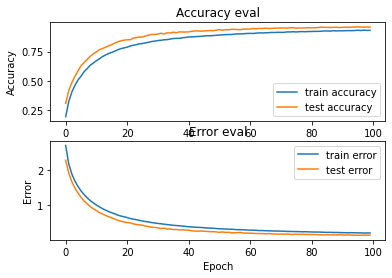

876/876 - 2s - loss: 0.1462 - accuracy: 0.9573 - 2s/epoch - 2ms/step



Test accuracy: 0.9573177099227905
1/1 [==============================] - 0s 112ms/step
Target: 1, Predicted label: [1]


In [11]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)


In [19]:
SAVED_MODEL_PATH = "model.h5"
model.save(SAVED_MODEL_PATH)


In [13]:
import pandas as pd

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
_mapping = {
    1:"Bis'mi",
    2:"Al-lahi",
    3:"Al-rahmaani",
    4:"Al-raheemi",
    5:"Alhamdu",
    6:"lillaahi",
    7:"Rabbil",
    8:"aalameen",
    9:"Ar-Rahmaan",
    10:"Ar-Raheem",
    11:"Maaliki",
    12:"Yumid",
    13:"Diin",
    14:"Iyyaka",
    15:"Na'abudu",
    16:"Iyyaka",
    17:"Nasta'een",
    18:"Ihdinas",
    19:"Siraatal",
    20:"Mustaqeem",
    21:"Siraatal",
    22:"Ladheena",
    23:"An'amta",
    24:"Alaihim",
    25:"Ghayril",
    26:"Maghdubi",
    27:"Alaihim",
    28:"Wala al-dalina"}

In [16]:
SAMPLE_RATE = 22050
TRACK_DURATION = 2 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
file = '/content/003.wav'

def save_mfcc(file_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    mfcc_lst = []
    # we divide the track into 5 segments
    # to calculate sample per segment - we need to know the number of samples per track (which is the sample rate * the track duration )
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

    # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc - for each segment of signal
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_lst.append(mfcc.tolist())
    return mfcc_lst

In [17]:
!pip install librosa==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import librosa
import tensorflow as tf
import numpy as np
import math
SAVED_MODEL_PATH = "model.h5"
SAMPLE_RATE = 22050
TRACK_DURATION = 2 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

class _Keyword_Spotting_Service:
    """Singleton class for keyword spotting inference with trained models.

    :param model: Trained model
    """
    
    model = None
    _mapping = [
    "Bis'mi",
    "Al-lahi",
    "Al-rahmaani",
    "Al-raheemi",
    "Alhamdu",
    "lillaahi",
    "Rabbil",
    "aalameen",
    "Ar-Rahmaan",
    "Ar-Raheem",
    "Maaliki",
    "Yumid",
    "Diin",
    "Iyyaka",
    "Na'abudu",
    "Iyyaka",
    "Nasta'een",
    "Ihdinas",
    "Siraatal",
    "Mustaqeem",
    "Siraatal",
    "Ladheena",
    "An'amta",
    "Alaihim",
    "Ghayril",
    "Maghdubi",
    "Alaihim",
    "Wala al-dalina"
    ]
    _instance = None

    # generate predictions and confidence scores
    # def predict_with_confidence(model, x):
    #     # generate predictions and confidence scores for each input
    #     preds = model.predict(x)
    #     confs = int(np.max(preds, axis=-1))
    #     return preds, confs

    def predict(self, file_path):
        """

        :param file_path (str): Path to audio file to predict
        :return predicted_keyword (str): Keyword predicted by the model
        """

        # extract MFCC
        # MFCCs = np.array([[-183.87974548339844, 131.75009155273438, 2.2060155868530273, -8.105782508850098, -38.07963562011719, 17.40044403076172, -0.6676614284515381, -22.161405563354492, -10.295568466186523, 6.563896179199219, -3.6954336166381836, -11.445362091064453, 9.491683959960938], [-180.80616760253906, 115.36853790283203, -2.8926031589508057, -9.07729721069336, -52.492637634277344, 26.909496307373047, -2.7331502437591553, -14.425968170166016, -19.478710174560547, 5.680357933044434, -1.7577323913574219, -16.35490608215332, 13.524815559387207], [-192.94027709960938, 91.42437744140625, -23.93356704711914, -23.16407012939453, -60.30923843383789, 32.025535583496094, 10.04941177368164, 0.4003942012786865, -24.948360443115234, 5.307590007781982, 1.5026012659072876, -26.008087158203125, 17.219728469848633], [-175.62313842773438, 101.17229461669922, -32.41350555419922, -30.539745330810547, -64.07801055908203, 31.093017578125, 12.911539077758789, 7.282844543457031, -30.573162078857422, 7.644656658172607, 4.2728986740112305, -30.014530181884766, 20.74167251586914], [-166.6313018798828, 105.19999694824219, -35.174930572509766, -30.445606231689453, -63.564903259277344, 27.228313446044922, 14.329790115356445, 15.870038986206055, -33.5143928527832, 8.455541610717773, 7.194486618041992, -29.158828735351562, 15.765297889709473], [-166.1154327392578, 110.21952819824219, -37.62902069091797, -28.95749282836914, -62.26484298706055, 23.820415496826172, 12.333368301391602, 15.781059265136719, -34.20686340332031, 4.830765247344971, 7.3923163414001465, -27.21042251586914, 9.298351287841797], [-166.02870178222656, 
# 121.54912567138672, -45.28936004638672, -26.586345672607422, -62.76194763183594, 27.857032775878906, 8.119768142700195, 10.21646785736084, -32.60343933105469, 4.115324020385742, 6.260907173156738, -25.593948364257812, 0.23342549800872803], [-163.90133666992188, 121.15217590332031, -41.218467712402344, -18.846481323242188, -57.43403625488281, 29.522968292236328, 0.46502673625946045, 4.530104160308838, -26.924739837646484, 5.935633659362793, 5.122352600097656, -17.716205596923828, -5.116012096405029], [-134.5664825439453, 154.80996704101562, -31.109590530395508, -16.877721786499023, -54.75687789916992, 26.409751892089844, -11.305870056152344, -2.671182632446289, -19.20587921142578, 8.538867950439453, 4.430681228637695, -13.631662368774414, -4.969356060028076]])
        MFCCs = np.array(self.preprocess(file_path))
        
        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = self.model.predict(MFCCs) # a 2d array [[]]
        predicted_index = np.argmax(predictions)
        # index return the index which has highest score
        confs = tf.nn.softmax(predictions)
        # Get corresponding probability value for predicted class
        confidence_score = predictions[0][predicted_index]
        predicted_keyword = self._mapping[predicted_index]
        # print('prediction',predicted_index,predicted_keyword)
        return predicted_keyword, confidence_score


    def preprocess(self, file_path, num_mfcc=13, n_fft=2048, hop_length=512,num_segments=10):
        mfcc_lst = []
        # we divide the track into 5 segments
        # to calculate sample per segment - we need to know the number of samples per track (which is the sample rate * the track duration )
        samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # process all segments of audio file
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            # extract mfcc - for each segment of signal
            mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T

            # store only mfcc feature with expected number of vectors
            if len(mfcc) == num_mfcc_vectors_per_segment:
                mfcc_lst.append(mfcc.tolist())
        return mfcc_lst[0]


def Keyword_Spotting_Service():
    """Factory function for Keyword_Spotting_Service class.

    :return _Keyword_Spotting_Service._instance (_Keyword_Spotting_Service):
    """

    # ensure an instance is created only the first time the factory function is called
    if _Keyword_Spotting_Service._instance is None:
        _Keyword_Spotting_Service._instance = _Keyword_Spotting_Service()
        _Keyword_Spotting_Service.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _Keyword_Spotting_Service._instance




if __name__ == "__main__":

    # create 2 instances of the keyword spotting service
    kss = Keyword_Spotting_Service()
    kss1 = Keyword_Spotting_Service()

    # check that different instances of the keyword spotting service point back to the same object (singleton)
    assert kss is kss1

    # make a prediction
    keyword, condfidence_score = kss.predict("002.wav")
    print(keyword)
    print('Confidence',condfidence_score)

<ipython-input-27-9804f04c18e4>:100: FutureWarning: Pass y=[0.02628682 0.03317782 0.03789439 ... 0.06536973 0.06302683 0.05670235], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
<ipython-input-27-9804f04c18e4>:100: FutureWarning: Pass y=[0.05048585 0.05129176 0.05542339 ... 0.05260923 0.03931705 0.02578977], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
<ipython-input-27-9804f04c18e4>:100: FutureWarning: Pass y=[0.01763017 0.01292829 0.00694799 ... 0.16284892 0.16833648 0.17078859], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish]

1/1 [==============================] - 0s 165ms/step
lillaahi
Confidence 0.99961436


## try to Split audio and to predict each word

In [44]:
audio = ['test3.wav']
Ayah = []
for f in audio:
  # create 2 instances of the keyword spotting service
    kss = Keyword_Spotting_Service()
    kss1 = Keyword_Spotting_Service()

    # check that different instances of the keyword spotting service point back to the same object (singleton)
    assert kss is kss1

    # make a prediction
    keyword, condfidence_score = kss.predict(f)
    print(keyword)
    
    print('Confidence',condfidence_score)
    if condfidence_score >.7:
      Ayah.append(keyword)


1/1 [==============================] - 0s 30ms/step
Na'abudu
Confidence 0.58477926


<ipython-input-27-9804f04c18e4>:100: FutureWarning: Pass y=[-0.00873394 -0.01433475 -0.01386717 ... -0.01177989 -0.00525943
  0.00422414], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
<ipython-input-27-9804f04c18e4>:100: FutureWarning: Pass y=[0.01262137 0.0186716  0.02377728 ... 0.06622896 0.06485698 0.06262731], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
<ipython-input-27-9804f04c18e4>:100: FutureWarning: Pass y=[ 0.05842116  0.05321707  0.04928912 ... -0.09084725 -0.0872895
 -0.09458985], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[

In [45]:
Ayah

[]